In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

In [12]:
!unzip -qq face-mask-12k-images-dataset.zip

In [1]:
cd /content/drive/MyDrive/DeepLearningTasks/FaceMaskDetection

/content/drive/MyDrive/DeepLearningTasks/FaceMaskDetection


### Parameters *Setting*

In [16]:
%%writefile config.py

batch_size = 32
epochs = 3
lr = 0.0001
width = height = 128

Overwriting config.py


### Imports and Data

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from config import *
import cv2
import matplotlib.pyplot as plt

In [3]:
data_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True
)

train_data = data_generator.flow_from_directory(
    "/content/Face Mask Dataset/Train",
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
)

val_data = data_generator.flow_from_directory(
    "/content/Face Mask Dataset/Validation",
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
)

print(np.bincount(train_data.labels))
print(np.bincount(val_data.labels))

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
[5000 5000]
[400 400]


### My Model

In [4]:
model = tf.keras.models.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
])

### Transfer learning


In [45]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(width, height, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
    )

for layer in base_model.layers:
  layer.trainable = False


model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')                          
])

In [5]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                             metrics=['accuracy'])

In [6]:
model.fit(train_data,
          steps_per_epoch=train_data.samples/batch_size,
          validation_data=val_data,
          validation_steps=val_data.samples/batch_size,
          batch_size = batch_size,
          epochs=epochs,
          )

Epoch 1/3
312/312 [==============================] - 855s 3s/step - loss: 0.0747 - accuracy: 0.9746 - val_loss: 0.9972 - val_accuracy: 0.5975
Epoch 2/3
312/312 [==============================] - 852s 3s/step - loss: 0.0221 - accuracy: 0.9915 - val_loss: 0.0184 - val_accuracy: 0.9950
Epoch 3/3
312/312 [==============================] - 850s 3s/step - loss: 0.0129 - accuracy: 0.9964 - val_loss: 0.0088 - val_accuracy: 0.9975


In [7]:
model.save("/content/drive/MyDrive/DeepLearningTasks/FaceMaskDetection/model.h5")

### Test

In [10]:
test_data_path = '/content/Face Mask Dataset/Test'
model = load_model('model.h5')

data_generator = ImageDataGenerator(rescale = 1./255)

test_data = data_generator.flow_from_directory(
    "/content/Face Mask Dataset/Test",
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)

model.evaluate(test_data)

Found 992 images belonging to 2 classes.
31/31 [==============================] - 20s 638ms/step - loss: 0.0266 - accuracy: 0.9909


[0.026626737788319588, 0.9909273982048035]

### Confusion Matrix

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis = 1)
print('confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

target_names = list(test_data.class_indices.keys())
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

confusion Matrix
[[482   1]
 [  8 501]]
Classification Report
              precision    recall  f1-score   support

    WithMask       0.98      1.00      0.99       483
 WithoutMask       1.00      0.98      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



### Inference on Test data





In [13]:
def predict(path_image):


    model = load_model('model.h5')

    image = cv2.imread(path_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width,height))
    image = image/255.0
    img2 = image.reshape(1, width, height, 3)

    plt.imshow(image)

    result = model.predict(img2)
    prediction = np.argmax(result)
    print(result)
    print(prediction)

    if prediction == 0:
      print("With Mask")
      # color = (255, 0, 0)

    else:
      print("Without Mask")
      # color = (255, 0, 255)

[[2.6421967e-05 9.9997354e-01]]
1
Without Mask


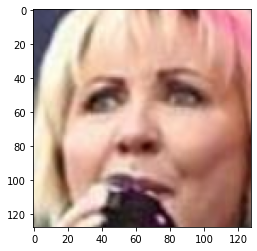

In [14]:
predict('/content/input/12.png')

[[0.9895923  0.01040768]]
0
With Mask


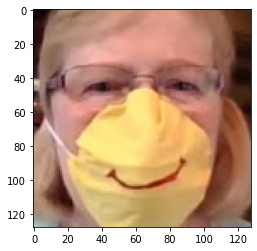

In [15]:
predict('/content/input/09.png')

### Preproccess and Inference

In [ ]:
!pip install retina-face

In [23]:
def proccess_predict(image_path):

    from retinaface import RetinaFace
    model = load_model('model.h5')
    faces = RetinaFace.extract_faces(img_path= image_path, align= True)
    image = faces[0]
    image = cv2.resize(image, (width, height))
    image = image / 255.0
    img2 = image.reshape(1, width, height, 3)

    plt.imshow(image)

    result = model.predict(img2)
    prediction = np.argmax(result)

    print(result)

    if prediction == 0:
      print("With Mask")
      # color = (255, 0, 0)

    else:
      print("Without Mask")
      # color = (255, 0, 255)

[[3.1988645e-07 9.9999964e-01]]
Without Mask


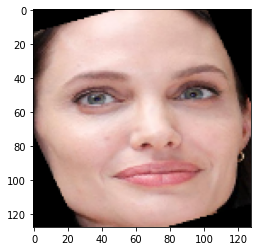

In [25]:
proccess_predict('/content/input/03.jpg')